# Wrangling & Analyzing Twitter Data 

In [67]:
# import libraries
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import os

import re
import tweepy

## 1. Gathering Data

### WeRateDogs twitter archive (Local file)

In [68]:
# Read the twitter_archive_enhanced.csv file as dataframe with name df
df = pd.read_csv('twitter-archive-enhanced.csv')
df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Tweet image prediction file (URL)

In [69]:
# Download the tweet image predictions from 
# the Udacity server using Request library
url = ('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/'
                         '599fd2ad_image-predictions/image-predictions.tsv')

# Create dataframe from TSV
df_prediction = pd.read_csv(url, delimiter='\t')


### Query Tweet API 

import tweepy
from tweepy import OAuthHandler
import json
import csv
import sys
import os
import time


# Twitter API authentication 
consumer_key = '4NdirZUZXl8a7KlZqNol1BsY7'
consumer_secret = 'qJsVpmYPwXv4PQVU6dabQe0sE209W3V4Z8GzBSKTIavhI7sFUs'
access_token = '1068843573083160578-3jt8syOheNGRAztkjfocYVBgfxAi1p'
access_secret = 'eb2axcWwq5l1LG0CYuHe102rIYasLmVL9ToY6RkoomkNi'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, 
                 wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True)

tweet_ids = list(df.tweet_id)

start = time.time()
for index, tweet in enumerate(tweet_ids):
    if index % 100 == 0:
        print(index)
        time.sleep(1)
print(time.time()-start)
print()

#Twitter Query using tweet_id information from the df.

tweet_data = {}
for index, tweet in enumerate(tweet_ids):
    try:
        if index % 100 == 0:
            print(index)
        tweet_status = api.get_status(tweet, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_data[str(tweet)] = tweet_status._json
        time.sleep(0.1)
    except:
        print("Error in Index: {} ".format(index))


In [70]:
with open('tweet_json.txt') as file:
    data = json.load(file)
    
df_list = []

for tweet_id in data.keys():
    retweets = data[tweet_id]['retweet_count']
    favorites = data[tweet_id]['favorite_count']# + data[tweet_id]['favourites_count']
    df_list.append({'tweet_id': tweet_id,
                        'retweets': retweets,
                        'favorites': favorites})
    
tweets_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweets', 'favorites'])
tweets_df.sample(5)

,tweet_id,retweets,favorites
2275,667174963120574464,84,246
1437,695794761660297217,840,3354
2006,672095186491711488,377,1016
2038,671486386088865792,212,589
1787,676957860086095872,857,2302


## 2. Accessing Data

There are there dataframes:
1. df has the tweet's text, rating, and dog category
2. df_predictions has the dog breed prediciton from a neural netwrok algrithm
3. tweets_df has retweet and favourite counts

Requirements: 
1. After gathering the above pieces of data,visual and programmatical accessment is performed for quality and tidiness issues. 
2. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation must be assessed.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [72]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [73]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [74]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [75]:
df_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [76]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id     2342 non-null object
retweets     2342 non-null int64
favorites    2342 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


In [77]:
tweets_df.head()

,tweet_id,retweets,favorites
0,892420643555336193,8360,38183
1,892177421306343426,6176,32745
2,891815181378084864,4086,24658
3,891689557279858688,8496,41507
4,891327558926688256,9199,39696


In [78]:
df_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [79]:
df['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Lola         10
Penny        10
Tucker       10
Bo            9
Winston       9
Sadie         8
the           8
Buddy         7
Daisy         7
Toby          7
an            7
Bailey        7
Rusty         6
Leo           6
Bella         6
Stanley       6
Koda          6
Milo          6
Dave          6
Jax           6
Scout         6
Oscar         6
Jack          6
Sammy         5
           ... 
Crawford      1
Burt          1
Tug           1
Pupcasso      1
Kloey         1
Wafer         1
Tuck          1
Gin           1
Richie        1
Dot           1
Roscoe        1
Jennifur      1
Mairi         1
Dug           1
Covach        1
space         1
Harnold       1
Bluebert      1
Jazz          1
Batdog        1
Rodney        1
Bode          1
Lambeau       1
Barclay       1
Rorie         1
Maude         1
Filup         1
Rumble        1
Ginger        1
Obie          1
Name: name, Length: 957,

In [80]:
df_prediction.p1.value_counts()
df_prediction.p2.value_counts()
df_prediction.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
Staffordshire_bullterrier         32
chow                              32
beagle                            31
cocker_spaniel                    31
Pekinese                          29
Pomeranian                        29
toy_poodle                        29
Pembroke                          27
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
d

### Quality issues
#### df
1. The name column contains faulty dog names, e.g. 'a', 'an, 'the' etc.  
2. `timestamp`: should be timestamp rather than object
3. `retweeted_status_timestamp`: should be timestamp rather than object
4. `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id` should be string r
5. Incorrect rating_numerator and rating_denominator: The rating_numerator and rating_denominator can be any positive integer. However, there are a couple of records with a wrong rating because the author always parsed the first fraction. There are also some tweets without a rating but the author mistakenly parsed a rating for it. 
6. Retweet entries

#### df_prediction
7. p1, p2, p3 inconsistent capitalization (sometimes first letter is capital)
8. missing data (only has 2075 entries instead of 2356)

#### tweet_df
9. missing data (only has 2347 entries instead of 2356)

### Tidiness
#### df
1. Each dog stage is treated as a separat column which needs to be consolidated into one.

#### df_prediction
2. There should be a column that prints the final breed prediction by summarizing p1 p2 p3 and p1_dog p2_dog p3_dog

## 3. Cleaning Data

In [81]:
# Make copies of each dataframe
df_clean = df.copy()
df_clean_prediction = df_prediction.copy()
df_clean_tweets = tweets_df.copy()

### Meaningless dog names
##### Define
Replace the faulty name with None or correct name
(Due to large number of faulty names in the dataset, only names that have "a" will be fixed)

##### Code

In [82]:
# replacing faulty names with None value or corrected Name

def replace_names(row):
    # Only try to replace name if it is 'a'
    if row['name'] == 'a':    
        #get text from row
        text = row['text']
        
        # get list of words from the text
        word_list = text.split()

        # defaults to no name
        name = 'None'

        # get name from 'named {}'
        if 'named' in word_list:
            # Get the next word after 'named'
            name_pos = word_list.index('named') + 1
            name = word_list[name_pos]

        # get name from 'name is {}'
        elif 'name is' in text:
            # Get the next word after 'name is' (skip 'is')
            name_pos = word_list.index('name') + 2
            name = word_list[name_pos]

        #only replace the 'name' column (with no period)
        row['name'] = name.replace('.','')
    
    return row
    

df_clean = df_clean.apply(replace_names, axis=1)

##### Test

In [83]:
# Check if there is name as 'a'
'a' in df_clean['name']

False

### Wrong data types: timestamp and retweeted_status_timestamp
##### Define 
Change timestamp and retweeted_status_timestamp to datetimes

##### Code

In [84]:
# To datetime
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.retweeted_status_timestamp = pd.to_datetime(df_clean.retweeted_status_timestamp)

##### Test

In [85]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

### Wrong data types of in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id

##### Define 
Change in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id to string

In [86]:
df_clean['in_reply_to_status_id']=df_clean['in_reply_to_status_id'].apply(lambda x : str(int(x)) if not np.isnan(x) else x)
df_clean['in_reply_to_user_id'] = df_clean['in_reply_to_user_id'].apply(lambda x : str(int(x)) if not np.isnan(x) else x)
df_clean['retweeted_status_id'] = df_clean['retweeted_status_id'].apply(lambda x : str(int(x)) if not np.isnan(x) else x)
df_clean['retweeted_status_user_id'] = df_clean['retweeted_status_user_id'].apply(lambda x : str(int(x)) if not np.isnan(x) else x)

##### Test

In [87]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[n

###  Incorrect rating_numerator and rating_denominator
##### Define
Remake rating_numerator and rating_denominator.
##### Code

In [88]:
# examine the data set where rating denominators is not equal to 10. 
# They have higher chance to have wrong ratings 
wrong_denominator = df.query('rating_denominator != 10')[['text','rating_denominator']]

In [89]:
# check the size of the data with possible incorrect rating_denominator
wrong_denominator['text'].shape

(23,)

In [90]:
wrong_denominator.head()

,text,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,0
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the flo...,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,7
784,"RT @dog_rates: After so many requests, this is...",11


In [91]:
# the size of the data set is not large so print each text to see where the problem is 
for index,row in wrong_denominator.iterrows():
    print (row['text'])

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
@docmisterio account started on 11/15/15
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Bluebert. He just saw that both #Fin

In [92]:
# change the type of rating_numerator and rating_denominator into float
df_clean['rating_numerator']=df_clean['rating_numerator'].astype(float)
df_clean['rating_denominator']=df_clean['rating_denominator'].astype(float)

In [93]:
# use the last fraction number as the rating
for index,row in wrong_denominator.iterrows():
    rating=[]
    rating=re.findall(r'(\d+)\/(\d+)\/*(\d+)*',row['text'],flags=0)
    if (len(rating) > 0):
        # if there are more than one rating with format x/y, use the last rating. 
        df_clean.set_value(index,'rating_denominator',rating[-1][-2])
        
    else:
        df_clean.set_value(index,'rating_denominator',np.nan)


C:\Users\Jenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


##### Test

In [94]:
df_clean.loc[wrong_denominator.index][['text','rating_denominator' ]]

,text,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,10.0
342,@docmisterio account started on 11/15/15,15.0
433,The floofs have been released I repeat the flo...,70.0
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,7.0
784,"RT @dog_rates: After so many requests, this is...",10.0
902,Why does this never happen at my front door......,150.0
1068,"After so many requests, this is Bretagne. She ...",10.0
1120,Say hello to this unbelievably well behaved sq...,170.0
1165,Happy 4/20 from the squad! 13/10 for all https...,10.0
1202,This is Bluebert. He just saw that both #Final...,10.0


### Some entries are retweets
##### Define
Identify and exlude tweets that have a retweeted_status because the tweet is a retweet and therefore not original.
##### Code

In [95]:
# only select the data that have 'retweeted_status_id ' as NaN
df_clean = df_clean[df_clean['retweeted_status_id'].isnull()==True]

##### Test

In [96]:
# check if there is any non-null entries in column 'retweeted_status_id'. should return 0
df_clean[df_clean['retweeted_status_id'].notnull()==True].shape[0]

0

### p1, p2, p3 inconsistent capitalization
##### Define
Make all strings in p1, p2, and p3 lowerrcase

##### Code

In [97]:
df_clean_prediction['p1'] = df_clean_prediction['p1'].str.lower()
df_clean_prediction['p2'] = df_clean_prediction['p2'].str.lower()
df_clean_prediction['p3'] = df_clean_prediction['p3'].str.lower()

##### Test

In [98]:
df_clean_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### df_prediction only has 2075 entries instead of 2356  
##### Define
Create a new dataframe by merging df_prediction into df_clean
##### Code

In [99]:
# Left join df_prediction to df, the merged data size is same as archive
df1 = df_clean
df2 = df_clean_prediction

df_clean_final = pd.merge(df1, df2, how='left', on=['tweet_id'])

### tweet_df only has 2347 entries instead of 2356
##### Define
Create a new dataframe by merging tweet_df into df_clean_final
##### Code

In [100]:
df_clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id     2342 non-null object
retweets     2342 non-null int64
favorites    2342 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


In [101]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns]

In [102]:
# Left join df_clean_tweets to df_clean_final, the merged data size is same as df_clean_final

df1 = df_clean_final
df2 = df_clean_tweets

df_clean_tweets['tweet_id'] = df_clean_tweets['tweet_id'].astype(np.int64)
df_clean_final = pd.merge(df1, df2, how='left', on=['tweet_id'])

### Each dog stage is treated as a separat column which needs to be consolidated into one
##### Define 
Convert four dog stages into a single stage variable.
##### Code

In [103]:
# make a copy of the df_clean_final
df1 = df_clean_final.copy()
df1 = df1[['tweet_id', 'doggo', 'floofer','pupper','puppo']]

In [104]:
# replace 'None' with Pandas NaN
df1 = df1.replace('None', np.nan)

In [105]:
# get the column name of four dog stages
cols = df1.columns.difference(['tweet_id'])

# join four separate stages into one
df_clean_final['stage'] = df1[cols].apply(lambda x: ', '.join(x.dropna()), 1)

#drop separate stages
df_clean_final = df_clean_final.drop(cols, axis=1)

##### Text

In [106]:
df_clean_final.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,8360.0,38183.0,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,True,pekinese,0.090647,True,papillon,0.068957,True,6176.0,32745.0,


In [107]:
# this is to check if multiple dog stages are joined properly
df_clean_final.query('name == "Pinot"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites,stage
567,785639753186217984,NaN,NaN,2016-10-11 00:34:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/785639753...,...,False,sea_urchin,0.006106,False,echidna,0.005442,False,2441.0,8384.0,"doggo, pupper"


### Create a breed prediction column
##### Define 
Create a breed_predict column
##### Code

In [126]:
for index, row in df_clean_final.iterrows():
    if row['p1_dog'] == True:
        df_clean_final.set_value(index,'breed_predict',row['p1'])
        
    elif row['p2_dog'] == True:
        df_clean_final.set_value(index,'breed_predict',row['p2'])
        
    elif row['p3_dog'] == True:
        df_clean_final.set_value(index,'breed_predict',row['p3'])
        
    else:
        df_clean_final.set_value(index,'breed_predict','Not a dog')


C:\Users\Jenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
C:\Users\Jenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Jenna\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [109]:
df_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 28 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null float64
p1                            1994 non-null object
p1_conf                       1994 non-null float64
p1_dog              

## 4. Store Data

In [110]:
df_clean_final.to_csv('twitter_clean.csv', index=False)

## 5. Analyzing, and Visualizing Data

### Most Common Dog Breeds

In [127]:
dog_breeds = df_clean_final['breed_predict'].value_counts()

Text(0.5,1,'Most common dog breeds')

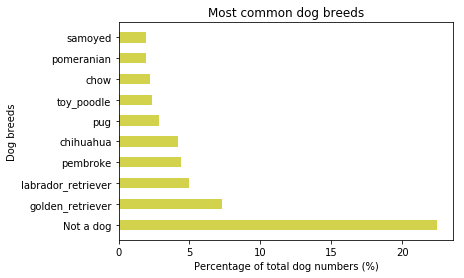

In [134]:
# plot the top 10 most common dog breeds
dog_breeds_t10 = dog_breeds[0:10]
ind = np.arange(dog_breeds_t10.shape[0])  # the x locations for the groups
width = 0.5
xticks = np.asarray(dog_breeds_t10.index)
y = np.asarray(dog_breeds_t10.values)/df_clean_final.shape[0]*100
                     
plt.barh(ind, y, width, color='y', alpha=.7,tick_label=xticks);

# title and labels
plt.ylabel('Dog breeds')
plt.xlabel('Percentage of total dog numbers (%)')
plt.title('Most common dog breeds')

It can be seen that neural network failed to predict around 20% of the dog images. 
The most common dog breed is golden retriever with around 7%, followed by labrador retrieve with 5% and pembrooke,  

### Rating of Each DogStage

Whether specific dog stage has higher/lower rate than others?  

In [194]:
# check the number of tweets for each listed dog stage
stage_number =  pd.DataFrame(df_clean_final[["tweet_id","stage"]].groupby(['stage']).count())
stage_number

,tweet_id
stage,
,1831
doggo,75
"doggo, floofer",1
"doggo, pupper",10
"doggo, puppo",1
floofer,9
pupper,224
puppo,24


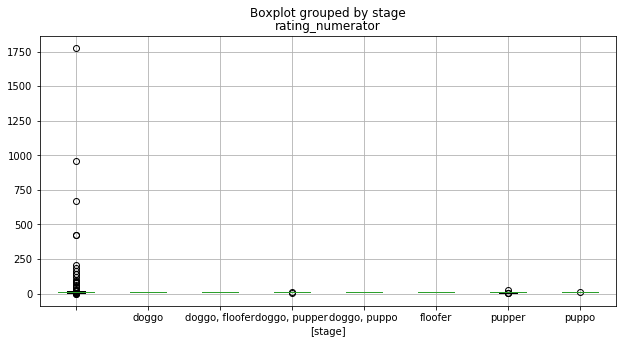

In [135]:
# boxplot of each dog stage
df_clean_final.boxplot(column=['rating_numerator'], by=['stage'],figsize=(10,5))

Above figure shows that teh rating_denominator outliers should be excluded before the dataset can be analyzed properly.  

Exclude the rating_numerator outlier, only analyze the dogs with rating_denominator of 10

In [114]:
#  use discribe function to find the Q1 ans Q3
df_clean_final.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,retweets,favorites
count,2.175000e+03,2175.000000,2175.000000,1994.000000,1994.000000,1.994000e+03,1.994000e+03,2174.000000,2174.000000
mean,7.371205e+17,13.215172,10.477241,1.203109,0.593941,1.344195e-01,6.024848e-02,2656.362925,8609.924103
std,6.748668e+16,47.725696,6.958764,0.560777,0.271954,1.006807e-01,5.089067e-02,4705.968218,12631.996640
min,6.660209e+17,0.000000,7.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,51.000000
25%,6.768432e+17,10.000000,10.000000,1.000000,0.362857,5.393988e-02,1.619283e-02,575.000000,1828.250000
50%,7.098528e+17,11.000000,10.000000,1.000000,0.587635,1.174550e-01,4.950530e-02,1271.000000,3885.000000
75%,7.894226e+17,12.000000,10.000000,1.000000,0.846285,1.951377e-01,9.159438e-02,3041.750000,10702.750000
max,8.924206e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,84010.000000,164830.000000


In [115]:
# use Q1 and Q3 to calculate the outlier. 
outlier_l = 10 - 1.5*(12-10)
outlier_h = 12 + 1.5* (12-10)

In [116]:
# exclude the outlier
rate_breed = df_clean_final[(df_clean_final['rating_numerator']<outlier_h)&(df_clean_final['rating_numerator']>outlier_l)]

In [117]:
# only analyze dogs with rating_denominator of 10
rate_breed = rate_breed.query('rating_denominator == 10')

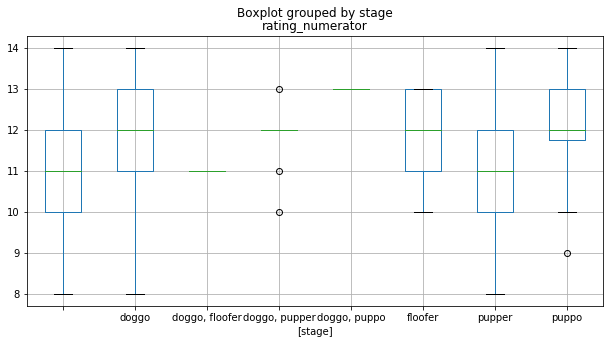

In [118]:
# boxplot of each dog stage
rate_breed.boxplot(column=['rating_numerator'], by=['stage'],figsize=(10,5))

It appers that @dog_rates tends to rate lower on pupper. 

### Popularity of Dog Breeds
there are two variables to represent the popularity of dog breeds, number of favorites and retweets. following two plots shows the top 10 dog breeds with highest median favourite counts and median retweet count. (Use of mean count leads to different ranking, but median is used in this analysis to avoid affect from large outliers) 

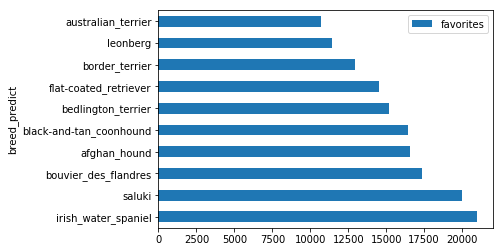

In [213]:
favorite_dog = pd.DataFrame(df_clean_final.groupby(['breed_predict'])['favorites'].median())
# Plot the 10 most favorite dog breeds in bar chart
favorite_dog.sort_values(['favorites'],ascending=False)[0:10].plot(kind='barh')

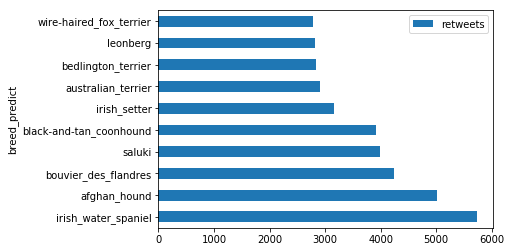

In [211]:
retweeet_dog = pd.DataFrame(df_clean_final.groupby(['breed_predict'])['retweets'].median())
# Plot the 10 most favorite dog breeds in bar chart
retweeet_dog.sort_values(['retweets'],ascending=False)[0:10].plot(kind='barh')

At different dog stage, there are different favourite dog breeds

### Analyzing Timestamp
To analyze timestamp of each tweet and when @dog_rates likes to send a tweet throughout the day

In [121]:
# load cleaned data and convert the timestamp to the right format
df = pd.read_csv('twitter_clean.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 28 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2175 non-null object
jpg_url                       1994 non-null object
img_num                       1994 non-null float64
p1                            1994 non-null object
p1_conf                       1994 non-null float64
p1_dog                 

Extract hour information form the timestamp and plot the number of tweets against hour. 

In [123]:
# Extract hour from time stamp
df['hour']=df['timestamp'].apply(lambda x : x.hour)

Text(0.5,1,'Tweet count against hour')

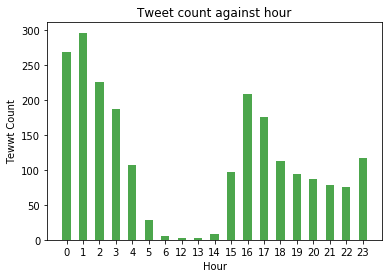

In [124]:
# plot the number of tweets against hour of the day 
tweet_time = df['hour'].value_counts().sort_index()
ind = np.arange(tweet_time.shape[0])
width = 0.5
xticks = np.asarray(tweet_time.index)
y = np.asarray(tweet_time.values)
plt.bar(ind, y, width, color='g', alpha=.7,tick_label=xticks);

# title and labels
plt.ylabel('Tewwt Count')
plt.xlabel('Hour')
plt.title('Tweet count against hour')

The barchat shows that @dog_rates actively tweeting at midnight and late afternoon, and never sent a tweet bewteen 7AM to 11AM. 